## Семинар 10: "Генерация текстов"

ФИО: Притугин Михаил Алексеевич

In [45]:
import numpy as np
import re
from torch import nn
from torch.autograd import Variable
import matplotlib.pyplot as plt
import torch
from torch.utils.data import Dataset, DataLoader
import sys
from IPython.display import clear_output
from tqdm.auto import tqdm
import progressbar
from sklearn.model_selection import train_test_split
%matplotlib inline

Этот семинар посвящен чат-ботам. Вам предстоит реализовать модель, генерирующую определенные тексты. В качестве текстов можно взять сборник цитат умных людей, предсказаний и т.д. На семинаре мы используем данные https://github.com/alvations/Quotables/blob/master/author-quote.txt

При реализации задания вы можете пользоваться кодом из этого примера: <a href=https://github.com/spro/practical-pytorch/blob/master/char-rnn-generation/char-rnn-generation.ipynb>Generating Shakespeare with a Character-Level RNN</a>

### Часть 1: подготовка данных

Реализуйте датасет для дальнейшего обучения (будем использовать batch size=1)

In [2]:
lines = [x.split('\t')[1].strip() for x in open('author-quote.txt').readlines()]

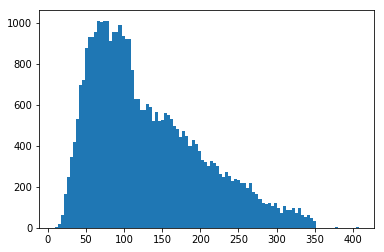

In [3]:
plt.hist(list(map(len, lines)), bins=100);

(array([2.000e+00, 7.000e+01, 1.830e+02, 3.550e+02, 4.920e+02, 0.000e+00,
        6.880e+02, 8.810e+02, 1.025e+03, 1.173e+03, 0.000e+00, 1.229e+03,
        1.302e+03, 1.361e+03, 1.333e+03, 0.000e+00, 1.336e+03, 1.326e+03,
        1.239e+03, 1.291e+03, 1.212e+03, 0.000e+00, 1.080e+03, 1.068e+03,
        9.700e+02, 8.350e+02, 0.000e+00, 7.860e+02, 7.920e+02, 7.740e+02,
        7.640e+02, 0.000e+00, 7.370e+02, 7.100e+02, 6.990e+02, 6.950e+02,
        0.000e+00, 6.290e+02, 5.900e+02, 5.870e+02, 5.460e+02, 5.340e+02,
        0.000e+00, 4.780e+02, 4.620e+02, 4.620e+02, 4.100e+02, 0.000e+00,
        4.240e+02, 3.780e+02, 3.680e+02, 3.380e+02, 0.000e+00, 3.070e+02,
        3.350e+02, 2.500e+02, 2.810e+02, 0.000e+00, 2.330e+02, 2.310e+02,
        2.000e+02, 1.870e+02, 1.790e+02, 0.000e+00, 1.760e+02, 1.420e+02,
        1.260e+02, 1.280e+02, 0.000e+00, 1.180e+02, 1.150e+02, 9.000e+01,
        7.500e+01, 0.000e+00, 6.300e+01, 8.300e+01, 6.000e+01, 4.800e+01,
        0.000e+00, 4.000e+01, 3.300e+0

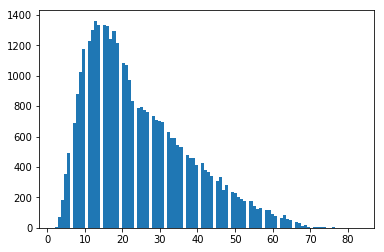

In [4]:
plt.hist(list(map(lambda x: len(x.split()), lines)), bins=100)

In [5]:
line = lines[0]

In [6]:
line

'If you live to be a hundred, I want to live to be a hundred minus one day so I never have to live without you.'

In [7]:
lines = list(filter(lambda x: len(x.split()) <= 50, lines))

In [8]:
np.random.seed(777)
torch.random.manual_seed(777)

In [9]:
class Vocabulary:
    def __init__(self, sentences):
        all_characters = set()
        for line in sentences:
            all_characters |= set(line)
        all_characters = list(sorted(all_characters))+['<eos>', '<go>']
        self.char_to_id = {x[1]:x[0] for x in enumerate(all_characters)}
        self.id_to_char = {x[0]:x[1] for x in enumerate(all_characters)}
        self.size = len(all_characters)

    def encode(self, line):
        return [self.char_to_id[x] for x in line]
    
    def decode(self, tokens):
        return ''.join([self.id_to_char[x] for x in tokens])

In [10]:
vocab = Vocabulary(lines)

In [11]:
assert vocab.decode(vocab.encode(lines[0])) == lines[0]

In [12]:
class Quotes(Dataset):
    def __init__(self, sentences, vocab):
        # Construct vocabulary + EOS & GO tokens
        self.sentences = sentences
        self.vocab = vocab
        self.go = self.vocab.char_to_id['<go>']
        self.eos = self.vocab.char_to_id['<eos>']
        
    def __len__(self):
        return len(self.sentences)
        
    def __getitem__(self, idx):
        tokens = self.vocab.encode(self.sentences[idx])
        _input = np.array([self.go]+tokens)
        _output = np.array(tokens+[self.eos])
        return _input, _output

In [13]:
def compose_batch(batch):
    order = np.argsort([-len(x[0]) for x in batch])
    lengths = np.array([len(x[0]) for x in batch])
    go = torch.zeros(len(batch), lengths[order[0]]).long()
    eos = torch.zeros(len(batch), lengths[order[0]]).long()
    mask = torch.zeros(len(batch), lengths[order[0]]).long()
    for i in range(len(batch)):
        current_go, current_eos = batch[i]
        go[i, :len(current_go)] = torch.tensor(current_go)
        eos[i, :len(current_eos)] = torch.tensor(current_eos)
        mask[i, :len(current_go)] = 1
    mask = mask[order]
    go = go[order]
    eos = eos[order]
    lengths = lengths[order]
    return go, eos, mask, lengths

In [14]:
dataset = Quotes(lines, vocab)

In [15]:
dataloader = DataLoader(dataset, shuffle=True, batch_size=64, collate_fn=compose_batch)

### Часть 2: определение модели

In [16]:
class OracleGRU(nn.Module):
    def __init__(self, vocabulary_size, embedding_size=128, hidden_size=256, layers=2):
        super(OracleGRU, self).__init__()
        self.embedding_size = embedding_size
        self.layers = layers
        self.hidden_size = hidden_size
        self.embedding = nn.Embedding(vocabulary_size, embedding_size)
        self.generator = nn.GRU(embedding_size, hidden_size, layers, batch_first=False)
        self.classifier = nn.Linear(hidden_size, vocabulary_size)

    def forward(self, _input, lengths):
        embedding = self.embedding(_input).transpose(0, 1)
        embedding = nn.utils.rnn.pack_padded_sequence(embedding, lengths)
        output, _ = self.generator(embedding)
        output = nn.utils.rnn.pad_packed_sequence(output)
        classes = self.classifier(output[0])
        return classes

    def generate(self, vocab, max_len=100):
        h = Variable(torch.zeros(self.layers, 1, self.hidden_size))
        current_token = '<go>'
        line = ''
        while (current_token != '<eos>') and len(line) < max_len:
            token = torch.Tensor([[vocab.char_to_id[current_token]]]).long()
            token_id = Variable(token, volatile=True)
            embedding = self.embedding(token_id)
            output, (h) = self.generator(embedding, (h))
            classes = self.classifier(output[0])
            classes_probs = nn.Softmax()(classes)
            sampler = torch.distributions.Categorical(classes_probs[0])
            new_token_id = sampler.sample().data.numpy().item()
            current_token = vocab.id_to_char[new_token_id]
            line = line + current_token
        return line

In [17]:
oracle = OracleGRU(vocab.size, embedding_size=32, hidden_size=64, layers=2)

### Часть 3: обучение модели

In [18]:
optimizer = torch.optim.RMSprop(oracle.parameters(), lr=0.001, weight_decay=1e-5)

In [19]:
criterion = nn.CrossEntropyLoss(reduction='none')

In [20]:
losses = []

In [21]:
def moving_average(a, n=20) :
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

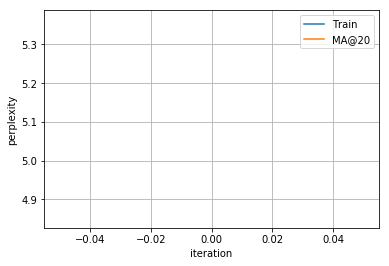

  1%|▏         | 7/536 [00:12<13:23,  1.52s/it]

KeyboardInterrupt: 

In [22]:
for epoch in range(1000):
    bar = progressbar.ProgressBar()
    for i, (go, eos, mask, length) in enumerate(tqdm.tqdm(dataloader, total=len(dataloader))):
        oracle.zero_grad()
        prediction = oracle(go, length).transpose(0, 1).transpose(1, 2)
        loss = (criterion(prediction, eos)*mask.float()).mean()
        loss.backward()
        [x.grad.clamp_(-1, 1) for x in oracle.parameters()]
        optimizer.step()
        losses.append(np.exp(loss.item()))
        if i % 50 == 0:
            clear_output(True)
            plt.plot(losses, label='Train')
            plt.plot(moving_average(losses), label='MA@20')
            plt.xlabel('iteration')
            plt.ylabel('perplexity')
            plt.legend()
            plt.grid()
            plt.show()

In [23]:
oracle.generate(vocab)

/Users/m.pritugin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
/Users/m.pritugin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


'lMooq mtn. rmgIi euig.5aibl shrtuoee cn,  amnh<go>etUn sfP "lin.tle eok y s o ri lels . <eos>'

### Часть 4: оценивание модели

<i> Приведите примеры сгенерированных предложений </i>

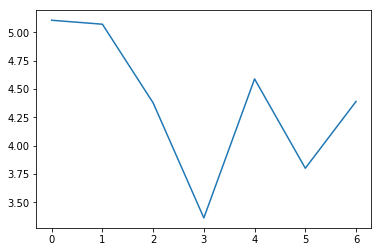

In [24]:
plt.plot(losses)

In [25]:
for i in range(5):
    print(oracle.generate(vocab))
    print("-----------------------------------------------------------------------------------------")

/Users/m.pritugin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
/Users/m.pritugin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


p$heMor,p snaeotlhe  avsPeab  Jefaehpeud.nvh  oo eo t e wolamr +" e  joseo ltieot eo  ru tai m lmtl,
-----------------------------------------------------------------------------------------
,bryhhysidlei  sb o  eoa mns aaiphh   eets  suoeannioif hern Ir neefkfdf etu m*d..iseogedhusgoionam 
-----------------------------------------------------------------------------------------
+tQsasue bhwiy asunsati m K<eos>
-----------------------------------------------------------------------------------------
Vmcep dd uutlpo bllno. fiayttru isun eecwntep 1hoovpioaZ;pjwnuor sa.linde stluls Ice xa Vd.hoeea shi
-----------------------------------------------------------------------------------------
",wtG nl n  aloat otav  emmbrs nte eio ennmnl  Y rh<eos>
-----------------------------------------------------------------------------------------


## HW 1 (3 балла)
1. Обучить сеть с LSTM вместо GRU
2. Сделать разбиение train-test и нарисровать графики зависимости перплексии от числа эпох
3. Подобрать гиперпараметры, добиться лучшей перплексии чем с параметрами по умолчанию

In [68]:
class OracleLSTM(nn.Module):
    def __init__(self, vocabulary_size, embedding_size=128, hidden_size=256, layers=2):
        super(OracleLSTM, self).__init__()
        self.embedding_size = embedding_size
        self.layers = layers
        self.hidden_size = hidden_size
        self.embedding = nn.Embedding(vocabulary_size, embedding_size)
        self.generator = nn.LSTM(embedding_size, hidden_size, layers, batch_first=False)
        self.classifier = nn.Linear(hidden_size, vocabulary_size)

    def forward(self, _input, lengths):
        embedding = self.embedding(_input).transpose(0, 1)
        embedding = nn.utils.rnn.pack_padded_sequence(embedding, lengths)
        output, _ = self.generator(embedding)
        output = nn.utils.rnn.pad_packed_sequence(output)
        classes = self.classifier(output[0])
        return classes

    def generate(self, vocab, max_len=100):
        h = Variable(torch.zeros(self.layers, 1, self.hidden_size))
        c = Variable(torch.zeros(self.layers, 1, self.hidden_size))
        current_token = '<go>'
        line = ''
        while (current_token != '<eos>') and len(line) < max_len:
            token = torch.Tensor([[vocab.char_to_id[current_token]]]).long()
            with torch.no_grad():
                token_id = Variable(token)
            embedding = self.embedding(token_id)
            output, (h, c) = self.generator(embedding, (h, c))
            classes = self.classifier(output[0])
            classes_probs = nn.Softmax()(classes)
            sampler = torch.distributions.Categorical(classes_probs[0])
            new_token_id = sampler.sample().data.numpy().item()
            current_token = vocab.id_to_char[new_token_id]
            line = line + current_token
        return line

In [35]:
oracle = Oracle2(vocab.size, embedding_size=32, hidden_size=64, layers=2)

### Обучение модели

In [36]:
optimizer = torch.optim.RMSprop(oracle.parameters(), lr=0.001, weight_decay=1e-5)

In [37]:
criterion = nn.CrossEntropyLoss(reduction='none')

In [38]:
train, test = train_test_split(lines, test_size=0.2)

In [39]:
vocab = Vocabulary(lines)

In [40]:
train = Quotes(train, vocab)
test = Quotes(test, vocab)

In [41]:
train = DataLoader(train, shuffle=True, batch_size=64, collate_fn=compose_batch)
test = DataLoader(test, shuffle=True, batch_size=64, collate_fn=compose_batch)

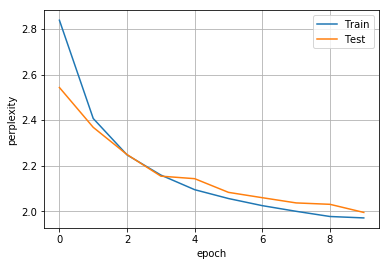

In [46]:
train_losses = []
test_losses = []
for epoch in range(10):
    EPOCH_TRAIN = []
    EPOCH_TEST = []
    for i, (go, eos, mask, length) in enumerate(tqdm(train, total=len(train))):
        oracle.zero_grad()
        prediction = oracle(go, length).transpose(0, 1).transpose(1, 2)
        loss = (criterion(prediction, eos)*mask.float()).mean()
        loss.backward()
        [x.grad.clamp_(-1, 1) for x in oracle.parameters()]
        optimizer.step()
        EPOCH_TRAIN.append(np.exp(loss.item()))
    train_losses.append(np.mean(EPOCH_TRAIN))
    for i, (go, eos, mask, length) in enumerate(tqdm(test, total=len(test))):
        prediction = oracle(go, length).transpose(0, 1).transpose(1, 2)
        loss = (criterion(prediction, eos)*mask.float()).mean()
        EPOCH_TEST.append(np.exp(loss.item()))
    test_losses.append(np.mean(EPOCH_TEST))
    clear_output(True)
    plt.plot(train_losses, label='Train')
    plt.plot(test_losses, label='Test')
    plt.xlabel('epoch')
    plt.ylabel('perplexity')
    plt.legend()
    plt.grid()
    plt.show()

In [54]:
oracle.generate(vocab)

/Users/m.pritugin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  del sys.path[0]


'Not say Exdip guaking for keeps the ficknow get of instant peploy fduct of difting to gode too. 2whi'

### ----------- Подбор --------------

In [60]:
oracle = Oracle2(vocab.size, embedding_size=64, hidden_size=128, layers=2)

In [63]:
optimizer1 = torch.optim.RMSprop(oracle.parameters(), lr=0.01, weight_decay=1e-5)
optimizer2 = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer1, 5)

In [64]:
criterion = nn.CrossEntropyLoss(reduction='none')

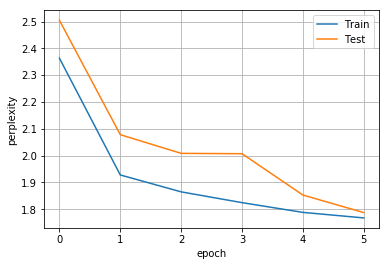

KeyboardInterrupt: 

In [65]:
train_losses = []
test_losses = []
for epoch in range(10):
    EPOCH_TRAIN = []
    EPOCH_TEST = []
    for i, (go, eos, mask, length) in enumerate(tqdm(train, total=len(train))):
        oracle.zero_grad()
        prediction = oracle(go, length).transpose(0, 1).transpose(1, 2)
        loss = (criterion(prediction, eos)*mask.float()).mean()
        loss.backward()
        [x.grad.clamp_(-1, 1) for x in oracle.parameters()]
        optimizer1.step()
        EPOCH_TRAIN.append(np.exp(loss.item()))
    train_losses.append(np.mean(EPOCH_TRAIN))
    for i, (go, eos, mask, length) in enumerate(tqdm(test, total=len(test))):
        prediction = oracle(go, length).transpose(0, 1).transpose(1, 2)
        loss = (criterion(prediction, eos)*mask.float()).mean()
        EPOCH_TEST.append(np.exp(loss.item()))
    test_losses.append(np.mean(EPOCH_TEST))
    clear_output(True)
    plt.plot(train_losses, label='Train')
    plt.plot(test_losses, label='Test')
    plt.xlabel('epoch')
    plt.ylabel('perplexity')
    plt.legend()
    plt.grid()
    plt.show()
    optimizer2.step()

In [70]:
oracle.generate(vocab)

/Users/m.pritugin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  del sys.path[0]


'Sorth can made any televil inflined.<eos>'

In [72]:
for i in range(20):
    print(oracle.generate(vocab))
    print("------------------------------------------------------------------------------------")

/Users/m.pritugin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  del sys.path[0]


Liberty if they 'the actor Fleerzolent there is because they like creates that himse, there is nor l
------------------------------------------------------------------------------------
Prople are whatsen if I know around. That's well, the world Arranda rich and kind, that's funny.<eos>
------------------------------------------------------------------------------------
I was just a progects as developing enUraced, to that.<eos>
------------------------------------------------------------------------------------
As a mirror one makes themselves done in this competitions to his discressor. Hould have you to thin
------------------------------------------------------------------------------------
Our best, I recourse when I was doing a senses of women. Badnage came backed.<eos>
------------------------------------------------------------------------------------
I didn't goe to accredible that you are after that. I love to winning to him, I felt create a new gr
---------------------------